## 필요 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import time
import pickle
import string

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize, pos_tag
np.random.seed(2018)
import nltk
nltk.download('wordnet')
from top2vec import Top2Vec

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from scipy import linalg

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/heojiyeon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2022-12-08 01:04:57.953574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# !pip install top2vec
# !pip install gensim

## 데이터 불러오기
- year, month 열 만들기
- 각 year별로 size 확인

In [2]:
tin=pd.read_csv('tinder_google_play_reviews.csv' ) # 틴더 데이터셋
hin=pd.read_csv('hinge_google_play_reviews 2.csv' ) # 범블 데이터셋
bum=pd.read_csv('bumble_google_play_reviews.csv' ) # 힌지 데이터셋

In [3]:
tin.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,2c6cda3b-db40-4745-9b7d-674ff4c58295,Taleiya Peña,https://play-lh.googleusercontent.com/a-/ACNPE...,I'm 22 years old. I've had tinder on and off s...,1,0,13.15.1,2022-10-07 02:56:37,NaN,NaN
1,4c97ef51-a7b7-40e4-9df3-37be2c565209,Shannan Matthews,https://play-lh.googleusercontent.com/a/ALm5wu...,"Just got randomly banned with no explanation, ...",1,0,12.17.0,2022-10-07 02:47:10,NaN,NaN
2,7696fd09-bd98-4f86-821e-dc1a7c525fde,Lisa Hopkins,https://play-lh.googleusercontent.com/a-/ACNPE...,Rubbish u got to pay see pick,1,0,13.17.0,2022-10-07 02:39:41,NaN,NaN
3,6f764d16-995e-40c2-9c49-a7855c4ab5d0,Alyce Hopkins,https://play-lh.googleusercontent.com/a-/ACNPE...,Kicked me off and won't let me on says I'm ban...,1,0,13.18.2,2022-10-07 02:13:28,NaN,NaN
4,0f2b0142-c0e6-4aaf-83b7-3ea499eaf466,Romanian SwoleJer,https://play-lh.googleusercontent.com/a-/ACNPE...,This app has the most good looking women on it...,4,0,13.17.0,2022-10-07 01:57:04,NaN,NaN


In [4]:
hin.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,719c5f8d-8bb0-4f03-91a4-1476688dff0b,Martian V1,https://play-lh.googleusercontent.com/a-/ACNPE...,Nothing but fake profiles.,1,0,NaN,2022-09-17 02:37:57,NaN,NaN
1,71fe7821-6f92-4707-91f7-f05693489592,Larry,https://play-lh.googleusercontent.com/a-/ACNPE...,Too many fake profiles. It used to be trustabl...,1,0,9.6.1,2022-09-17 02:08:36,NaN,NaN
2,a0eda94a-616f-49d2-a1bb-75dc8cd11737,jammphonic,https://play-lh.googleusercontent.com/a/ALm5wu...,"Terrible, buggy app",1,0,9.6.1,2022-09-17 01:45:06,NaN,NaN
3,3c5a4655-60eb-4568-856e-cf927caf317f,Abi,https://play-lh.googleusercontent.com/a-/ACNPE...,Many options for women not many good ones. Jus...,3,0,9.4.1,2022-09-17 00:26:23,NaN,NaN
4,db39106b-dd35-4ee9-be4e-7f23d7495d53,Vegito217,https://play-lh.googleusercontent.com/a/ALm5wu...,Yikes the app still aint changed. Also if I al...,1,0,9.6.1,2022-09-17 00:14:08,NaN,NaN


In [5]:
bum.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,5a6b6967-8b79-4433-8823-35316cc63d27,Akshay Biswal,https://play-lh.googleusercontent.com/a/ALm5wu...,It need to have better subscription paying opt...,1,0,5.286.0,2022-09-18 02:50:55,Thanks for reaching out to us! Bumble is alway...,2022-09-18 12:57:41
1,6d898fa7-596d-4e7b-9524-9bd799088bc3,Otaku Neko K.L,https://play-lh.googleusercontent.com/a-/ACNPE...,Wife and I are looking for other friends at si...,1,0,5.286.0,2022-09-18 01:38:31,NaN,NaN
2,89b564ea-84cb-4ba0-b451-70bb691c678d,Koko Wawa,https://play-lh.googleusercontent.com/a/ALm5wu...,How do I cancel payment,3,0,5.286.0,2022-09-18 01:30:39,Hi Koko. This will depend on how you subscribe...,2022-09-18 12:58:11
3,f50dde62-5c2e-4246-8971-0158578936cf,Wafiq Essop,https://play-lh.googleusercontent.com/a-/ACNPE...,They have fake profilea to like you so as to g...,1,0,NaN,2022-09-17 23:36:57,NaN,NaN
4,a0537432-05f8-4f4e-b50d-71f47b4e4b79,Ryokk Music,https://play-lh.googleusercontent.com/a-/ACNPE...,No me funcionó.,1,0,5.286.0,2022-09-17 22:59:21,NaN,NaN


## year, month열 만들기

In [6]:
# 틴더
y=[] # 연도
m=[] # 월

for i in tin['at']: # 날짜 컬럼 'at'
    i=i.split('-') 
    y.append(i[0])
    m.append(i[2])
    
tin['year']=y
tin['month']=m

# 힌지
y1=[] # 연도
m1=[] # 월

for i in hin['at']: # 날짜열 'at'
    a1=i.split('-')
    y1.append(a1[0])
    m1.append(a1[2])
    
hin['year']=y1
hin['month']=m1

# 범블
y2=[] # 연도
m2=[] # 월

for i in bum['at']: # 날짜열 'at'
    a2=i.split('-')
    y2.append(a2[0])
    m2.append(a2[2])
    
bum['year']=y2
bum['month']=m2

# 앱별 연도별 size확인
print('2022년 틴터: {}, 힌지: {}, 범블: {}'.format(len(tin[tin.year=='2022']), len(hin[hin.year=='2022']),len(bum[bum.year=='2022'])))
print('2022년 틴터: {}, 힌지: {}, 범블: {}'.format(len(tin[tin.year=='2021']), len(hin[hin.year=='2021']),len(bum[bum.year=='2021'])))
print('2022년 틴터: {}, 힌지: {}, 범블: {}'.format(len(tin[tin.year=='2020']), len(hin[hin.year=='2020']),len(bum[bum.year=='2020'])))
print('2022년 틴터: {}, 힌지: {}, 범블: {}'.format(len(tin[tin.year=='2019']), len(hin[hin.year=='2019']),len(bum[bum.year=='2019'])))
print('2022년 틴터: {}, 힌지: {}, 범블: {}'.format(len(tin[tin.year=='2018']), len(hin[hin.year=='2018']),len(bum[bum.year=='2018'])))
print('2022년 틴터: {}, 힌지: {}, 범블: {}'.format(len(tin[tin.year=='2017']), len(hin[hin.year=='2017']),len(bum[bum.year=='2017'])))

2022년 틴터: 44759, 힌지: 6312, 범블: 21403
2022년 틴터: 59895, 힌지: 8846, 범블: 22900
2022년 틴터: 67672, 힌지: 18216, 범블: 21580
2022년 틴터: 86212, 힌지: 18456, 범블: 23280
2022년 틴터: 68865, 힌지: 5102, 범블: 11417
2022년 틴터: 63733, 힌지: 249, 범블: 10448


## 샘플링
- 각 데이터셋 별로 데이터 크기가 다르고 / 컴퓨터 메모리 등 컴퓨터 자원 상의 한계로
    - 데이터 양(행의 수)이 제일 적은 hinge 데이터 크기에 맞춰 샘플링 진행

In [7]:
# 틴더
tin22=tin[tin.year=='2022'].sample(6312, random_state=100) # 2022년
tin21=tin[tin.year=='2021'].sample(8846, random_state=100) # 2021년
tin20=tin[tin.year=='2020'].sample(18216, random_state=100) # 2020년
tin19=tin[tin.year=='2019'].sample(18456, random_state=100) # 2019년
tin18=tin[tin.year=='2018'].sample(5102, random_state=100) # 2018년
tin17=tin[tin.year=='2017'].sample(249, random_state=100) # 2017년
tin_sample=pd.concat([tin22,tin21,tin20,tin19,tin18,tin17])

# 범블
bum22=bum[bum.year=='2022'].sample(6312, random_state=200) # 2022년
bum21=bum[bum.year=='2021'].sample(8846, random_state=200) # 2021년
bum20=bum[bum.year=='2020'].sample(18216, random_state=200) # 2020년
bum19=bum[bum.year=='2019'].sample(18456, random_state=200) # 2019년
bum18=bum[bum.year=='2018'].sample(5102, random_state=200) # 2018년
bum17=bum[bum.year=='2017'].sample(249, random_state=200) # 2017년
bum_sample=pd.concat([bum22,bum21,bum20,bum19,bum18,bum17])

In [8]:
print(len(tin_sample), len(hin), len(bum_sample))

57181 57181 57181


## 문장단위로 분리
- Tinder 
- Hinge
- Bumble

### Tinder

In [9]:
#이모티콘 없애기 위한 전처리
T_review=[]
for i in tin_sample["content"]:
    CHANGE_FILTER='[^a-zA-Z0-9?!.]' # 숫자와 글자 .? ! 만 가지고오기
    q=re.sub(CHANGE_FILTER, " ", str(i)).strip() # 숫자와 글자 .? !를 공백으로 바꾼 후, 앞뒤 공백 제거
    total=q.lower() # 소문자로 변환
    T_review.append(total)
tin_sample['T_Review']=T_review

# 문장으로 쪼개기
tin_sample['sen']=tin_sample['T_Review'].str.split(".")

# 문장수준으로 행을 분리 (다른 열들의 값 보존함)
tin_df=tin_sample.copy()

tin_result_df = pd.DataFrame(columns = ['reviewId','at','thumbsUpCount','content','star'])
rd_loc = 0
begin = time.time() # 시작 시간

for i , row in tin_df.iterrows(): #객체 하나씩 불러오기
    User=row['reviewId']
    period=row['at']
    like=row['thumbsUpCount']
    star1=row['score']

    for s in row['sen']:
        CHANGE_FILTER='[^a-zA-Z0-9,!?]' # 숫자와 글자 .? ! 만 가지고오기
        q=re.sub(CHANGE_FILTER, " ", s).strip() # 숫자와 글자 .? !를 공백으로 바꾼 후, 앞뒤 공백 제거
        q=q.split(',') # , 기준으로 나누기
        tin_result_df.loc[rd_loc] = [User, period, like, q, star1] # result_df행에 각 값을 넣어주기
        rd_loc = rd_loc + 1
        
end = time.time() # 끝나는 시간
print(np.round((end - begin)/60),"분 소요")

#원본 데이터 변형될 일에 대비해 copy해두기
original_tin=tin_result_df.copy()

# vader알고리즘쓸때는 리스트형식으로 들어가면 안됨. 
# 따라서 데이터 프레임안에 존재하는 '[', ']'문자를 제거하기 위해서 아래코드를 돌림
a=[]
for s in tin_result_df['content']:
        CHANGE_FILTER='[^a-zA-Z0-9]' # 숫자와 글자만 가지고 오기
        q=re.sub(CHANGE_FILTER, " ", str(s)).strip() # 숫자와 글자를 공백으로 바꾼 후, 앞뒤 공백 제거
        a.append(q)
        
tin_result_df['content']=a
result1=tin_result_df[tin_result_df.content!=''] # 빈칸인 것들도 보여서 제거
result1

#최종 데이터 저장
result1.to_csv('Tinder_문장분리결과.csv')

12.0 분 소요


### hinge  

In [10]:
#이모티콘 없애기 위한 전처리
T_review=[]
for i in hin["content"]:
    CHANGE_FILTER='[^a-zA-Z0-9?!.]' # 숫자와 글자 .? ! 만 가지고오기
    q=re.sub(CHANGE_FILTER, " ", str(i)).strip() # 숫자와 글자 .? !를 공백으로 바꾼 후, 앞뒤 공백 제거
    total=q.lower() # 소문자로 변환
    T_review.append(total)
hin['T_Review']=T_review

# 문장으로 쪼개기
hin['sen']=hin['T_Review'].str.split(".")

# 문장수준으로 행을 분리 (다른 열들의 값 보존함)
hin_df=hin.copy()

hin_result_df = pd.DataFrame(columns = ['reviewId','at','thumbsUpCount','content','star'])
rd_loc = 0
begin = time.time()

for i , row in hin_df.iterrows(): #객체 하나씩 불러오기
    User=row['reviewId']
    period=row['at']
    like=row['thumbsUpCount']
    star1=row['score']

    for s in row['sen']:
        CHANGE_FILTER='[^a-zA-Z0-9,!?]' # 숫자와 글자 .? ! 만 가지고오기
        q=re.sub(CHANGE_FILTER, " ", s).strip() # 숫자와 글자 .? !를 공백으로 바꾼 후, 앞뒤 공백 제거
        q=q.split(',') # , 기준으로 나누기
        hin_result_df.loc[rd_loc] = [User, period, like,q,star1] #result_df행에 각 값을 넣어주기
        rd_loc = rd_loc + 1
        
end = time.time()
print(np.round((end - begin)/60),"분 소요")

#원본 데이터 변형될 일에 대비해 copy해두기
original_hin=hin_result_df.copy()

# vader알고리즘쓸때는 리스트형식으로 들어가면 안됨. 
# 따라서 데이터 프레임안에 존재하는 '[', ']'문자를 제거하기 위해서 아래코드를 돌림
a=[]
for s in hin_result_df['content']:
        CHANGE_FILTER='[^a-zA-Z0-9]' #숫자와 글자만 가지고오기
        q=re.sub(CHANGE_FILTER, " ", str(s)).strip() # 숫자와 글자를 공백으로 바꾼 후, 앞뒤 공백 제거
        a.append(q)
hin_result_df['content']=a
result2=hin_result_df[hin_result_df.content!=''] # 빈칸인 것들도 보여서 제거
result2

#최종 데이터 저장
result2.to_csv('Hinge_문장분리결과.csv')

13.0 분 소요


### Bumble 

In [11]:
#이모티콘 없애기 위한 전처리
T_review=[]
for i in bum_sample["content"]:
    CHANGE_FILTER='[^a-zA-Z0-9?!.]' # 숫자와 글자 .? ! 만 가지고오기
    q=re.sub(CHANGE_FILTER, " ", str(i)).strip() # 숫자와 글자 .? !를 공백으로 바꾼 후, 앞뒤 공백 제거
    total=q.lower() # 소문자로 변환
    T_review.append(total)
bum_sample['T_Review']=T_review

# 문장으로 쪼개기
bum_sample['sen']=bum_sample['T_Review'].str.split(".")

# 문장수준으로 행을 분리 (다른 열들의 값 보존함)
bum_df=bum_sample.copy()

bum_result_df = pd.DataFrame(columns = ['reviewId','at','thumbsUpCount','content','star'])
rd_loc = 0
begin = time.time() # 시작 시간

for i , row in bum_df.iterrows(): #객체 하나씩 불러오기
    User=row['reviewId']
    period=row['at']
    like=row['thumbsUpCount']
    star1=row['score']

    for s in row['sen']:
        CHANGE_FILTER='[^a-zA-Z0-9,!?]' # 숫자와 글자 .? ! 만 가지고오기
        q=re.sub(CHANGE_FILTER, " ", s).strip() # 숫자와 글자 .? !를 공백으로 바꾼 후, 앞뒤 공백 제거
        q=q.split(',') # , 기준으로 나누기
        bum_result_df.loc[rd_loc] = [User, period, like, q, star1] # result_df행에 각 값을 넣어주기
        rd_loc = rd_loc + 1
        
end = time.time() # 끝나는 시간
print(np.round((end - begin)/60),"분 소요")

#원본 데이터 변형될 일에 대비해 copy해두기
original_bum=bum_result_df.copy()

# vader알고리즘쓸때는 리스트형식으로 들어가면 안됨. 
# 따라서 데이터 프레임안에 존재하는 '[', ']'문자를 제거하기 위해서 아래코드를 돌림
a=[]
for s in bum_result_df['content']:
        CHANGE_FILTER='[^a-zA-Z0-9]' # 숫자와 글자만 가지고 오기
        q=re.sub(CHANGE_FILTER, " ", str(s)).strip() # 숫자와 글자를 공백으로 바꾼 후, 앞뒤 공백 제거
        a.append(q)
        
bum_result_df['content']=a
result3=bum_result_df[bum_result_df.content!=''] # 빈칸인 것들도 보여서 제거
result3

#최종 데이터 저장
result3.to_csv('Bumble_문장분리결과.csv')

16.0 분 소요


In [12]:
total=pd.concat([result1, result2, result3])

# 감정분석: Vader 

In [13]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer() # vader 감정 분석

# 틴더, 힌지, 범블 전체 데이터셋에 대한 감정분석
total['scores'] = total['content'].apply(lambda review: sid.polarity_scores(review)) # 감정분석 점수
total['compound']  = total['scores'].apply(lambda score_dict: score_dict['compound']) # 긍정 수치 -1~1 사이의 값
total['comp_score'] = total['compound'].apply(lambda c: 'pos' if c >=0 else 'neg') # c값이 0보다 크면 긍정, 아니면 부정

# total 데이터프레임과 합치기
total=pd.concat([total['reviewId'], total['scores'],total['compound'],
                 total['comp_score'],total['star'],total['content'],
                 total['thumbsUpCount'],total['at']],axis=1)
 
# csv 파일로 저장
total.to_csv('전체_문장수준_감정분석결과.csv')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/heojiyeon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 감정 평가
- 코드는 [1. 토픽모델링(Top2Vec)] 에 있지만, 순서상 [2. 토픽정하기]가 모두 완료된 후의 데이터셋을 대상으로 함

In [15]:
# Prediction 열 생성: compound 0.0 기준, 긍정 1 / 부정 -1
total['Prediction'] = total['content'].apply(lambda x: 1.0 if sid.polarity_scores(x)['compound'] > 0.0 else -1)

# 수기로 라벨링할 데이터 추출(긍정 4500, 부정 4500) 
# 별의 개수 5, 4는 긍정, 3은 중립, 2, 1은 부정으로 봄
a=total[total['star']>3]
a=a.sample(n=4500, random_state=100)
a['label']=None # 직접 라벨링할 열 생성
b=total[total['star']<3]
b=b.sample(n=4500, random_state=100)
b['label']=None # 직접 라벨링할 열 생성
s=pd.concat([a,b])

s.to_excel('감정성능평가_라벨링.xlsx')

In [16]:
# 수기로 채워넣은 데이터
s=pd.read_excel('감정성능평가_라벨링.xlsx')

# x[9]; Prediction 컬럼(pos=1, neg=0) / x[10]; 라벨링한 컬럼
s['Accuracy'] = s.apply(lambda x: 1 if x[9] == x[10] else 0, axis=1)

def conf_matrix(x): 
    if x[9] == 1 and x[10] == 1:
        return 'TP'
    elif x[9] == 1 and x[10] == -1:
        return 'FN'
    elif x[9] == -1 and x[10] == 1:
        return 'FP'
    elif x[9] == -1 and x[10] == -1:
        return 'TN'
    else:
        return 0
    
s['Conf_Matrix'] = s.apply(lambda x: conf_matrix(x), axis=1)

conf_vals = s.Conf_Matrix.value_counts().to_dict()
print(conf_vals)

# accuracy, precision, recall, f1 계산
accuracy = (conf_vals['TP'] + conf_vals['TN']) / (conf_vals['TP'] + 
                                                  conf_vals['TN'] + 
                                                  conf_vals['FP'] + 
                                                  conf_vals['FN'])

precision = conf_vals['TP'] / (conf_vals['TP'] + conf_vals['FP'])
recall = conf_vals['TP'] / (conf_vals['TP'] + conf_vals['FN'])
f1_score = 2*precision*recall / (precision + recall)

print('Accuracy: ', round(100 * accuracy, 2),'%',
      '\nPrecision: ', round(100 * precision, 2),'%',
      '\nRecall: ', round(100 * recall, 2),'%',
      '\nF1 Score: ', round(100 * f1_score, 2),'%')

{'TN': 3383, 'TP': 3259, 'FP': 1241, 'FN': 1117}
Accuracy:  73.8 % 
Precision:  72.42 % 
Recall:  74.47 % 
F1 Score:  73.43 %


## Top2Vec
- 문장단위수준으로 토픽모델링

In [17]:
# 중복 삭제
total2=total.drop_duplicates(['content'])

content_joined=total2['content'].apply(lambda x: "".join(x)) # 'content' 컬럼: 리뷰 내용
content_joined_list = list(content_joined)
content_joined_list[0]

'good'

### 토픽 모델링 실행

In [18]:
import time
embedding_model= "universal-sentence-encoder" # doc2vec의 임베딩 모델

min_count = 40
pos = " pos"
unit = "sentence" # 문장 단위

# 모델 이름
model_name = "[top2vec_"+ embedding_model+"]"+unit+ pos +"_total_"+"_min"+ str(min_count)
print(model_name)

begin = time.time()

# 토픽 모델링
model = Top2Vec(documents=content_joined_list, speed="learn", workers=8, min_count = min_count,
                embedding_model= embedding_model)
# 모델 저장
model.save(model_name)

end = time.time() # 끝나는 시간
print(np.round((end - begin)/60),"분 소요")

2022-12-07 18:49:02,030 - top2vec - INFO - Pre-processing documents for training


[top2vec_universal-sentence-encoder]sentence pos_total__min40


C:\Users\CJY\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-12-07 18:49:09,695 - top2vec - INFO - Downloading universal-sentence-encoder model
2022-12-07 18:49:14,725 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-12-07 18:49:44,011 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-12-07 18:52:25,756 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-12-07 18:52:42,758 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


4.0 분 소요


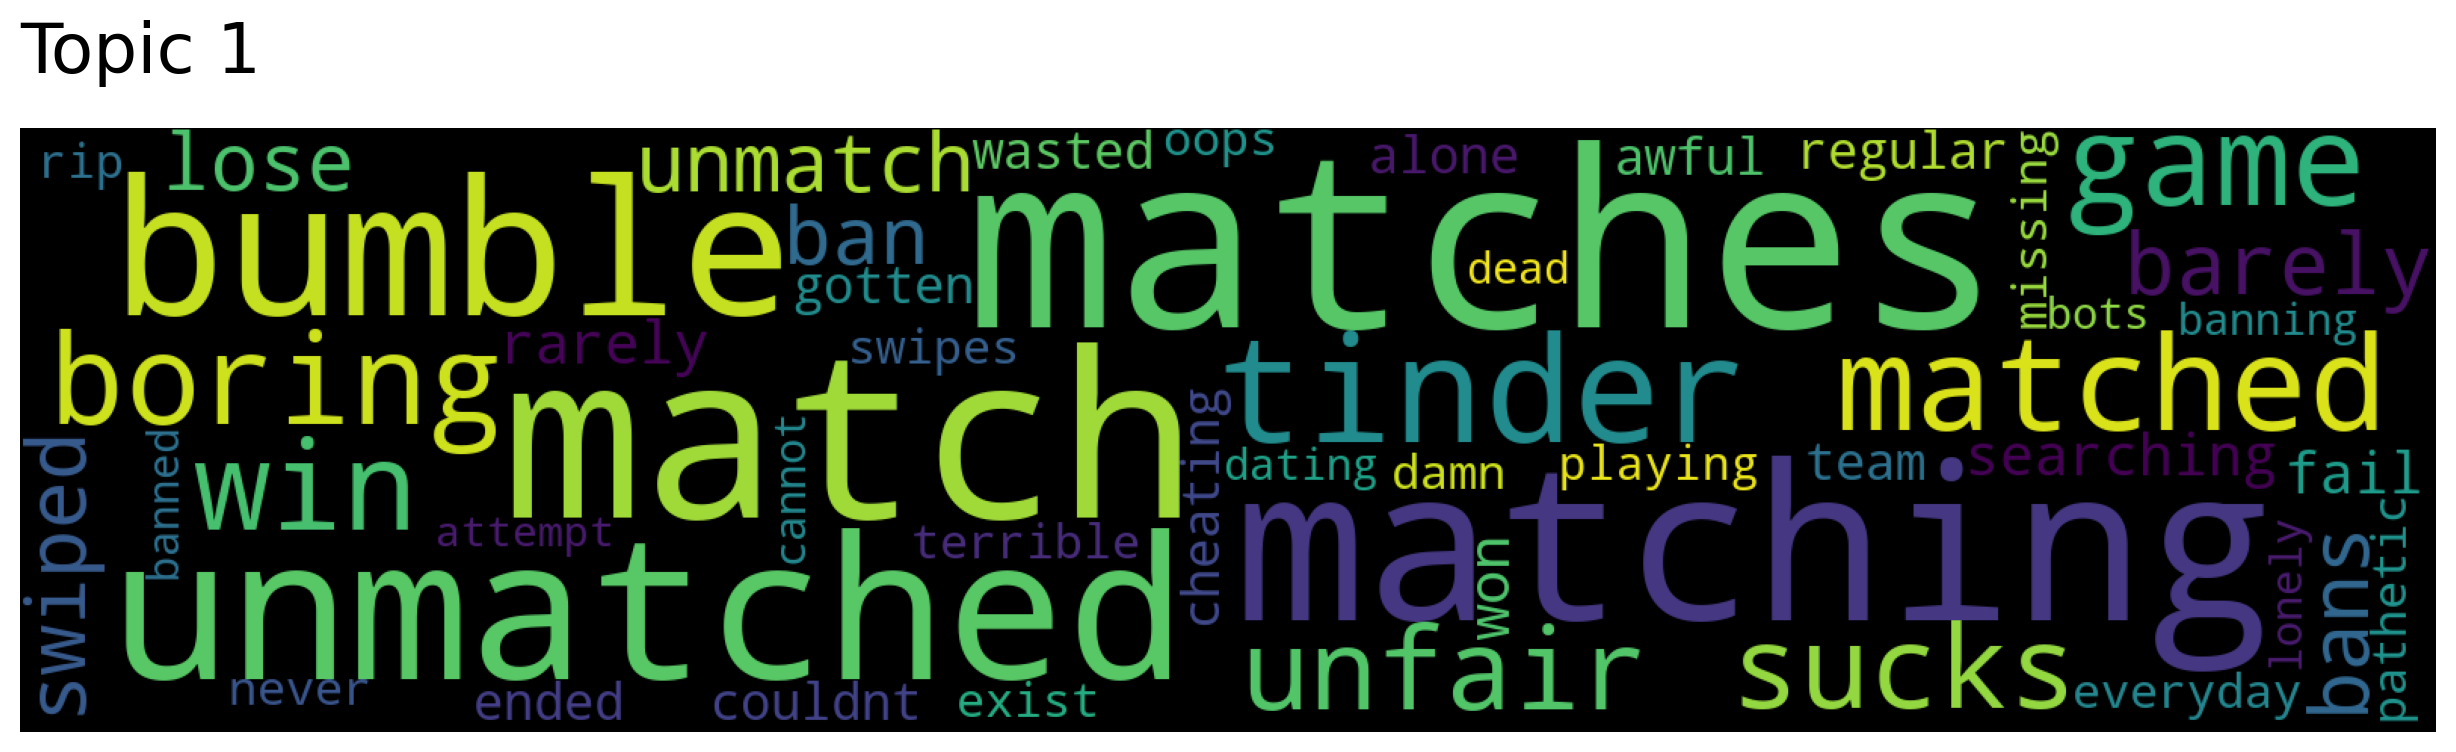

In [19]:
# 저장된 모델을 불러오기
model = Top2Vec.load('[top2vec_universal-sentence-encoder]sentence pos_total__min40')
model.get_num_topics() #최적의 토픽 갯수
model.generate_topic_wordcloud(1)

In [20]:
a = model.get_num_topics() # 최적의 토픽 개수
print('최적의 토픽 개수: {}개'.format(str(a)))

최적의 토픽 개수: 378개


In [21]:
topic_words, word_scores, topic_nums = model.get_topics(int(a)) # 토픽별 연관 단어, score
topic_words

array([['tinder', 'swiped', 'swiping', ..., 'smh', 'profiles', 'otp'],
       ['matches', 'match', 'matching', ..., 'bots', 'banned', 'attempt'],
       ['messages', 'messaging', 'message', ..., 'hacked', 'glitches',
        'banned'],
       ...,
       ['badoo', 'se', 'info', ..., 'snapchat', 'fix', 'uninstall'],
       ['countries', 'banned', 'scams', ..., 'stealing', 'violation',
        'smh'],
       ['ng', 'ka', 'aap', ..., 'leave', 'lmao', 'members']], dtype='<U13')

### 토픽별 문장, 문장별 스코어, 문장의 id

In [23]:
# 각 문장의 클러스터 번호 토픽 벡터를 반환함
top_size_arr = model.get_topic_sizes()
top_size = pd.DataFrame(top_size_arr).T
top_size.columns = ['number','topic_id']

# 토픽 저장할 데이터프레임
topic_docu = pd.DataFrame(data = [], columns = ["doc","score","doc_id","topic_no"])

topic_no = int(a) # 토픽 개수
#  데이터 프레임 만들기
for nth_topic in range(topic_no):  
    n_docus = top_size['number'].loc[nth_topic]
    # 0번 토픽부터 차례대로. 토픽별 문장, 문장별 스코어, 문장의 id
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=nth_topic, num_docs=n_docus)

    docs = pd.DataFrame(documents)
    scores = pd.DataFrame(document_scores)
    doc_ids = pd.DataFrame(document_ids)

    n_topic_docus = pd.concat([docs,scores,doc_ids],axis = 1)
    n_topic_docus.columns = ["doc","score","doc_id"]
    n_topic_docus["topic_no"] = nth_topic
    topic_docu = topic_docu.append(n_topic_docus)
    
# print(topic_docu.head(5),topic_docu.tail(5))

/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

                                                 doc     score doc_id topic_no
0  tinder used to be great especially tinder gold...  0.888215  58296        0
1                      tinder is not working so good  0.881826   3489        0
2  i ve always been a decent supporter of tinder ...  0.881666   9930        0
3                                 tinder is horrible  0.879996   4939        0
4                                 tinder is terrible  0.879812   3883        0                                                   doc     score doc_id  \
22                                  mi am gazit in8ma  0.390961  49697   
23                               match hi nh ho ra bc  0.377118  56711   
24  s i 1 n m r m  ch a c  b  z  coi th  g  ch u  ...  0.304690   2490   
25                 rasanya seperti sy menjadi ironman  0.293669  44438   
26                 bf cbc cz was x x  z  and n ccx se  0.187527  29459   

   topic_no  
22      377  
23      377  
24      377  
25      377  
26      377

/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_docu = topic_docu.append(n_topic_docus)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_62297/3285439914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [24]:
# topic number별 document 10개씩 뽑아와줘
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=10, num_docs=10)
documents

array(['nice good', 'nice n good', 'pretty awesome', 'nice up', 'good',
       'good9', 'p good', 'v good', 'p good b', 'good 1'], dtype=object)

### 토픽별 top 50 단어

In [25]:
file_name = '1차_클러스터별단어'+".xlsx" 

top_size_arr = model.get_topic_sizes()
top_size_arr

top_size = pd.DataFrame(top_size_arr).T
top_size.columns = ['number','topic_id']
top_size

top_words = []
for i in range(topic_words.shape[0]):
    top_words.append(str(topic_words[i]))
top_words = pd.DataFrame(top_words)

#topic별 top 50단어 저장할 데이터프레임
top_words.reset_index(inplace = True)
top_words.columns = ["topic_id","top50words"] #토픽별 top 50 단어

topic_words = pd.merge(top_size,top_words,on = "topic_id")
topic_words.to_excel(file_name)
topic_words

,number,topic_id,top50words
0,4007,0,['tinder' 'swiped' 'swiping' 'unmatch' 'swipes...
1,1025,1,['matches' 'match' 'matching' 'unmatched' 'bum...
2,1011,2,['messages' 'messaging' 'message' 'messaged' '...
3,894,3,['hadn' 'superlike' 'superlikes' 've' 'shouldn...
4,884,4,['banned' 'unbanned' 'unban' 'banning' 'bans' ...
...,...,...,...
373,32,373,['crazy' 'ridiculous' 'amazing' 'fool' 'stupid...
374,32,374,['mean' 'average' 'means' 'bad' 'terrible' 'go...
375,30,375,['badoo' 'se' 'info' 'help' 'per' 'sms' 'dolla...
376,28,376,['countries' 'banned' 'scams' 'paywall' 'pof' ...


## 2차 클러스터링을 위한 적절한 토픽 개수 찾기

- 계층적 클러스터 시각화 (데이터가 너무 커서 너무 오래 걸려서 토픽 개수를 줄이기 위함)
- 결과값보고 2차 클러스터 개수 정하기

### dendrogram 실행

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc

from matplotlib import pyplot as plt

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [55.0, 55.0, 65.0, 65.0],
  [40.0, 40.0, 60.0, 60.0],
  [20.0, 20.0, 50.0, 50.0],
  [5.0, 5.0, 35.0, 35.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [75.0, 75.0, 92.5, 92.5],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [125.0, 125.0, 142.5, 142.5],
  [115.0, 115.0, 133.75, 133.75],
  [83.75, 83.75, 124.375, 124.375],
  [20.0, 20.0, 104.0625, 104.0625],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [165.0, 165.0, 182.5, 182.5],
  [215.0, 215.0, 225.0, 225.0],
  [235.0, 235.0, 245.0, 245.0],
  [220.0, 220.0, 240.0, 240.0],
  [205.0, 205.0, 230.0, 230.0],
  [173.75, 173.75, 217.5, 217.5],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [315.0, 315.0, 325.0, 325.0],
  [292.5, 292.5, 320.0, 320.0],
  [262.5, 262.5, 306.25, 306.25],
  [335.0, 335.0, 345.0, 345.0],
  [365.0, 365.0, 3

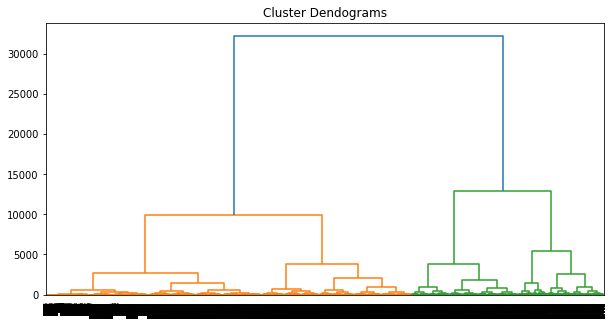

In [27]:
data=topic_docu[['score','topic_no']].values

# 맨 밑에 그래프 확인
plt.figure(figsize=(10, 5))
plt.title("Cluster Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))
dend

### 숫자크기 줄이기(덴드로그램보고 판단)

In [28]:
# 2차 클러스터링
# 위 dendrogram을 보고 판단한 적절한 토픽의 수(14)를 넣어 새롭게 토픽 모델링
topic_mapping = model.hierarchical_topic_reduction(num_topics=14)
topic_mapping

[[133,
  294,
  23,
  350,
  142,
  93,
  1,
  150,
  160,
  268,
  66,
  147,
  279,
  218,
  78,
  35,
  242,
  33,
  92,
  194,
  328,
  272,
  5,
  189,
  269,
  376,
  300,
  356,
  62,
  276,
  377,
  333,
  101,
  375,
  105,
  87,
  79,
  115,
  12,
  163,
  351,
  243,
  353,
  0],
 [128,
  198,
  234,
  86,
  176,
  355,
  159,
  220,
  370,
  34,
  161,
  213,
  120,
  114,
  81,
  153,
  254,
  267,
  125,
  199,
  347,
  274,
  168,
  260,
  336,
  237,
  374,
  75,
  197,
  257,
  183,
  280,
  65,
  246,
  227,
  238,
  144,
  325,
  196,
  232,
  91,
  322,
  188,
  102,
  146,
  293,
  247,
  118,
  314,
  190,
  50,
  67,
  327,
  373,
  136,
  122,
  186,
  162,
  139,
  224,
  283,
  295,
  315,
  332,
  338,
  339,
  346,
  367,
  117],
 [305,
  31,
  258,
  277,
  83,
  129,
  195,
  290,
  41,
  17,
  231,
  107,
  289,
  27,
  126,
  13,
  363,
  319,
  57,
  89,
  210,
  312,
  250,
  54],
 [3,
  266,
  344,
  342,
  70,
  202,
  226,
  271,
  56,
  172,
  85,


In [29]:
# 2번째 클러스터링한 클러스터 넘버까지 merge한 후 새롭게 파일 저장
empty_df = []
for a in topic_docu.topic_no:
    for m in range(len(topic_mapping)):
        if a in map(int, topic_mapping[m]):
            empty_df.append(m)
            
topic_docu['2nd_cluster_num']=empty_df       

# 데이터 합치기
total2.rename(columns={'content':'doc'}, inplace=True) # total2: 3사통합 중복 없앤 dataframe
total_final = pd.merge(total2, topic_docu, on='doc', how='inner')

# 데이터 저장
total_final.to_excel('2차클러스터완료.xlsx')
total.head(5)

,reviewId,scores,compound,comp_score,star,doc,thumbsUpCount,at,score,doc_id,topic_no,2nd_cluster_num
0,a6c7a357-da19-46a2-b265-855a9788306a,"{'neg': 0.0, 'neu': 0.954, 'pos': 0.046, 'comp...",0.2382,pos,1,if i lived in a more populated area it might ...,0,2020-09-23 10:13:55,0.505659,138523,243,6
1,08ac1b2f-a2f1-4ab4-8353-f148a2c47d84,"{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...",-0.4235,neg,1,but ultimately the whole thing is somewhat ri...,2,2020-02-01 15:02:02,0.701373,33584,370,5
2,96e5ca13-05f7-4c30-91f4-286066dc2a0d,"{'neg': 0.508, 'neu': 0.492, 'pos': 0.0, 'comp...",-0.4767,neg,1,fake profiles money scammers,0,2020-10-27 01:24:25,0.852542,34482,135,5
3,4ac73bb7-4dfe-4002-b9c6-1606ed772507,"{'neg': 0.126, 'neu': 0.874, 'pos': 0.0, 'comp...",-0.3804,neg,2,i ve been using the app for quite a while so i...,0,2021-01-12 16:47:57,0.701085,216063,41,7
4,f81cb35e-1777-4d00-8c0b-6e42b22937ae,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,4,while the permission for the camera is set to ...,107,2021-06-29 07:05:08,0.509364,204907,169,10
